In [20]:
from astropy.io import fits
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import glob, h5py
import fitsio
from tqdm import tqdm

plt.rcParams["axes.linewidth"]  = 1.0
plt.rcParams["xtick.direction"]  = "in"
plt.rcParams["ytick.direction"]  = "in"
plt.rcParams["legend.frameon"] = 'False'
plt.rcParams['figure.figsize'] = [10, 10]
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=13)

import os
if os.environ['USER'] == 'dhayaa':
    os.environ['PATH'] = f"{os.environ['PATH']}:/software/texlive-2021-el7-x86_64/bin/x86_64-linux"
    
    
COLORS = ["f07167","219ebc","c767ac", "59a270", "ffba0a"]
COLORS = ['#' + c if c[0] != '#' else c for c in COLORS ]

from cycler import cycler

# Update the default prop_cycle
plt.rcParams['axes.prop_cycle'] = cycler(color=COLORS)

from matplotlib.colors import LinearSegmentedColormap
custom_cmap = LinearSegmentedColormap.from_list(None, [COLORS[1], 'white', COLORS[2]])
custom_cmap.set_bad(color = 'xkcd:light gray', alpha = 0.2)

# DESDM validation

In [2]:
O = np.concatenate([fitsio.read('/project/chihway/dhayaa/DECADE/Balrog/v00_Blank_run_nogal/OldSrcExtractor_DES0804-0624_r-cat.fits'),
                    fitsio.read('/project/chihway/dhayaa/DECADE/Balrog/v00_Blank_run_nogal/OldSrcExtractor_DES0834-0833_r-cat.fits'),
                    fitsio.read('/project/chihway/dhayaa/DECADE/Balrog/v00_Blank_run_nogal/OldSrcExtractor_DES1455+1126_r-cat.fits')
                   ])
N = np.concatenate([fitsio.read('/project/chihway/dhayaa/DECADE/Balrog/v00_Blank_run_nogal/SrcExtractor_DES0804-0624_r-cat.fits'),
                    fitsio.read('/project/chihway/dhayaa/DECADE/Balrog/v00_Blank_run_nogal/SrcExtractor_DES0834-0833_r-cat.fits'),
                    fitsio.read('/project/chihway/dhayaa/DECADE/Balrog/v00_Blank_run_nogal/SrcExtractor_DES1455+1126_r-cat.fits')
                   ])

In [3]:
from sklearn.neighbors import BallTree

tree = BallTree(np.vstack([N['DELTAPEAK_J2000'], N['ALPHAPEAK_J2000']]).T * np.pi/180, leaf_size=2, metric="haversine")
d, j = tree.query(np.vstack([O['DELTAPEAK_J2000'],   O['ALPHAPEAK_J2000']]).T * np.pi/180)

d, j = d[:, 0], j[:, 0] #convert to 1d array
d    = d * 180/np.pi * 60*60 #convert to arcsec

/tmp/ipykernel_11599/1192637789.py:2: RuntimeWarning: invalid value encountered in divide
  snr  = O['FLUX_AUTO']/O['FLUXERR_AUTO']
/tmp/ipykernel_11599/1192637789.py:3: RuntimeWarning: invalid value encountered in divide
  mask = (O['FLUX_AUTO'] > 0) & (O['FLUX_AUTO']/O['FLUXERR_AUTO'] > 1)


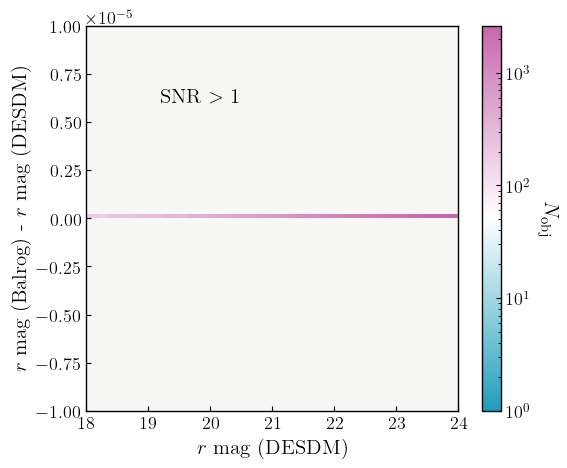

In [31]:
plt.figure(figsize = (6,5))
snr  = O['FLUX_AUTO']/O['FLUXERR_AUTO']
mask = (O['FLUX_AUTO'] > 0) & (O['FLUX_AUTO']/O['FLUXERR_AUTO'] > 1)
ind = np.argsort(snr); mask = mask[ind]
res = (N[j]['MAG_AUTO'][ind][mask] - O['MAG_AUTO'][ind][mask]) #residual

plt.hist2d(O['MAG_AUTO'][ind][mask], res, bins = 100, range = ((18, 24), (-1e-5, 1e-5)),
           cmap = custom_cmap, norm = mpl.colors.LogNorm(vmin = 1), rasterized = True);

cbar = plt.colorbar(); cbar.set_label(label = r'$N_{\rm obj}$', rotation = 270, labelpad = 20, size = 15)
plt.xlabel(r'$r$ mag (DESDM)', size = 15)
plt.ylabel(r'$r$ mag (Balrog) - $r$ mag (DESDM)', size = 15)

plt.text(0.2, 0.8, r'SNR $> 1$', size = 15, color = 'k', alpha = 1, transform = plt.gca().transAxes)
plt.ylim(-1e-5, 1e-5)

plt.savefig('./BalrogValidation.pdf', dpi = 300, bbox_inches = 'tight')

# Catalog distribution validation


In [10]:
metacal_columns = ['mcal_flux_noshear', 'mcal_T_noshear', 'mcal_T_ratio_noshear', 'mcal_s2n_noshear']


dtype = [('mcal_T_noshear', '>f8'), 
         ('mcal_T_ratio_noshear', '>f8'), 
         ('mcal_s2n_noshear', '>f8'), 
         ('mcal_flux_noshear', '>f8', 3), ]


with h5py.File('/project/chihway/dhayaa/DECADE/BalrogOfTheDECADE_20240123.hdf5', 'r') as f:
    
    N = 3_000_000
    
    Total_catalog_sim = np.zeros(N, dtype)
    
    mask = f['inj_class'][:] == 0
    for m in metacal_columns:
        Total_catalog_sim[m] = f[m][:][mask][:N]
        
    Tiles = np.unique(f['tilename'][:][mask][:N])
        

metacal_filelist = ['/project/chihway/data/decade/shearcat_final/metacal_output_%s.fits' % t.decode('utf-8') for t in Tiles]

Total_catalog = []
for f in tqdm(metacal_filelist):
    
    try:
        Total_catalog.append(fitsio.read(f, columns = metacal_columns))
    except:
        continue
    
Total_catalog_data = np.concatenate(Total_catalog)

100%|██████████| 426/426 [03:24<00:00,  2.08it/s]


In [11]:
def postprocess(X):
    
    new_array = np.zeros(len(X), 
                         dtype = [('SNR', '>f8'), 
                                  ('T', '>f8'),
                                  ('r', '>f8'),
                                  ('r-i', '>f8'),
                                  ('r-z', '>f8')
                                 ])
    
    new_array['SNR'] = X['mcal_s2n_noshear']
    new_array['T'] = X['mcal_T_noshear']
    new_array['r'] = X['mcal_flux_noshear'][:, 0]    
    
    Mask = ((new_array['r'] > 0) & (new_array['SNR'] > 0) & (new_array['T'] > -1))
    
    new_array = new_array[Mask]    
    
    new_array['SNR'] = np.log10(new_array['SNR'])
    new_array['T']   = np.log10(1 + new_array['T'])
    new_array['r'] = 30 - 2.5*np.log10(new_array['r'])
    
    i = 30 - 2.5*np.log10(X['mcal_flux_noshear'][:, 1])[Mask]
    z = 30 - 2.5*np.log10(X['mcal_flux_noshear'][:, 2])[Mask]
    
    Mask = ((new_array['r'] < 40) & (new_array['r'] > 14) & (i < 40) & (z < 40) & (new_array['T'] < 4.5))
    
    new_array = new_array[Mask]   
    
    new_array['r-i'] = new_array['r'] - i[Mask]
    new_array['r-z'] = new_array['r'] - z[Mask]
    
    print("SIZE:", len(new_array))
    return new_array

def dtype_to_float(X, t = '>f8'):
    
    return X.view(t).reshape(-1, len(X.dtype.names))

/tmp/ipykernel_5808/1563780814.py:23: RuntimeWarning: invalid value encountered in log10
  i = 30 - 2.5*np.log10(X['mcal_flux_noshear'][:, 1])[Mask]
/tmp/ipykernel_5808/1563780814.py:24: RuntimeWarning: invalid value encountered in log10
  z = 30 - 2.5*np.log10(X['mcal_flux_noshear'][:, 2])[Mask]


SIZE: 15904645


/tmp/ipykernel_5808/1563780814.py:23: RuntimeWarning: divide by zero encountered in log10
  i = 30 - 2.5*np.log10(X['mcal_flux_noshear'][:, 1])[Mask]
/tmp/ipykernel_5808/1563780814.py:24: RuntimeWarning: divide by zero encountered in log10
  z = 30 - 2.5*np.log10(X['mcal_flux_noshear'][:, 2])[Mask]


SIZE: 790552


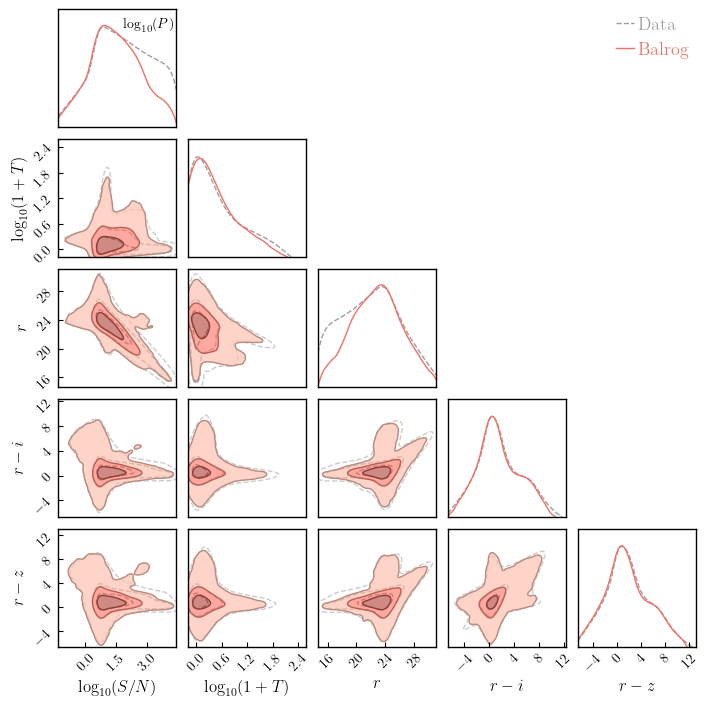

In [17]:
from chainconsumer import ChainConsumer

param_names = [r"$\log_{10}(S/N)$", r"$\log_{10}(1 + T)$", 
               r"$r$", 
               r"$r-i$", 
               r"$r-z$"]

c = ChainConsumer()

c.add_chain(dtype_to_float(postprocess(Total_catalog_data))[::1], parameters = param_names, name = 'Data')
c.add_chain(dtype_to_float(postprocess(Total_catalog_sim))[::1],  parameters = param_names, name = 'Balrog')

c.configure(sigmas = [0, 1, 2, 3], linewidths = 1, linestyles = ['--', '-'], spacing = 2, legend_kwargs = {'fontsize' : 13},
            colors=['grey', COLORS[0]], shade = [False, True], shade_alpha=[1.0, 0.7], bar_shade=False, usetex=True, serif=True)

fig = c.plotter.plot()

for i in range(0, 25, 6):
    fig.axes[i].set_yscale('log')
    yy = fig.axes[i].get_children()[0]._y
    fig.axes[i].set_ylim(np.max(yy) * 1e-4, np.max(yy) * 5)
    fig.axes[i].set_yticks([])
fig.axes[0].text(4.35, 0.8, r'$\log_{10}(P)$', ha = 'right', color = 'k', alpha = 1.0, size = 10) #, transform = fig.axes[6].transAxes)

plt.savefig('./Balrog_Triangle.pdf', dpi = 300, bbox_inches = 'tight')

# Detection rate curve

/tmp/ipykernel_5808/3259291649.py:23: RuntimeWarning: invalid value encountered in divide
  Transfer = np.histogram(m_i, bins = m_bins, weights = detect.astype(int))[0]/np.histogram(m_i, bins = m_bins)[0]


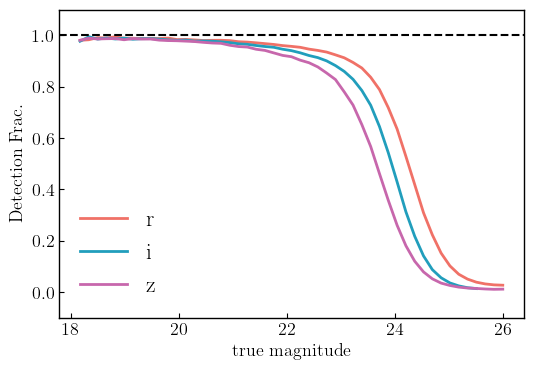

In [34]:
plt.figure(figsize = (6, 4))

m_bins   = np.linspace(18, 26, 50)
injclass = 0

with h5py.File('/project/chihway/dhayaa/DECADE/BalrogOfTheDECADE_20240123.hdf5', 'r') as cat:
    m_r = 30 - 2.5*np.log10(cat['true_FLUX_r'][:])[cat['inj_class'][:] == injclass]
    m_i = 30 - 2.5*np.log10(cat['true_FLUX_i'][:])[cat['inj_class'][:] == injclass]
    m_z = 30 - 2.5*np.log10(cat['true_FLUX_z'][:])[cat['inj_class'][:] == injclass]

    d = cat['d_arcsec'][:][cat['inj_class'][:] == injclass]
    dcont = cat['d_contam_arcsec'][:][cat['inj_class'][:] == injclass]
    flag  = cat['FLAGS_FOREGROUND'][:][cat['inj_class'][:] == injclass]

    mask = (dcont > 1.5) & (flag == 0)
    m_r, m_i, m_z, d = m_r[mask], m_i[mask], m_z[mask], d[mask]

    detect   = (d < 0.5) #& (cat['mcal_FLUX_r'][:]/cat['mcal_FLUX_r_ERR'][:] > 10)[cat['inj_class'][:] == injclass][mask]
    Transfer = np.histogram(m_r, bins = m_bins, weights = detect.astype(int))[0]/np.histogram(m_r, bins = m_bins)[0]
    plt.plot(m_bins[1:], Transfer, color = 'C0', label = 'r', lw = 2)

    detect   = (d < 0.5) #& (cat['mcal_FLUX_i'][:]/cat['mcal_FLUX_i_ERR'][:] > 10)[cat['inj_class'][:] == injclass][mask]
    Transfer = np.histogram(m_i, bins = m_bins, weights = detect.astype(int))[0]/np.histogram(m_i, bins = m_bins)[0]
    plt.plot(m_bins[1:], Transfer, color = 'C1', label = 'i', lw = 2)

    detect   = (d < 0.5) #& (cat['mcal_FLUX_z'][:]/cat['mcal_FLUX_z_ERR'][:] > 10)[cat['inj_class'][:] == injclass][mask]
    Transfer = np.histogram(m_z, bins = m_bins, weights = detect.astype(int))[0]/np.histogram(m_z, bins = m_bins)[0]
    plt.plot(m_bins[1:], Transfer, color = 'C2', label = 'z', lw = 2)

plt.xlabel('true magnitude', size = 13)
plt.ylabel('Detection Frac.', size = 13)

plt.ylim(-0.1, 1.1)
plt.axhline(1, color = 'k', ls = '--')
plt.legend(fontsize = 17, frameon = False)

plt.savefig('./Balrog_Completeness.pdf', dpi = 300, bbox_inches = 'tight')